In [1]:
# Import Packages and setup
import os
import logging
from collections import OrderedDict

import numpy as np
from astropy.table import Table as ApTable

import scarlet
import scarlet.display
import scarlet.constraints as sc

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

In [2]:
def trim_noise(flux, bg_rms, ratio=0.1):
    if len(flux.shape)==4:
        low_morph = np.all(flux<ratio*bg_rms[None,:,None,None], axis=1)
        low_flux = np.repeat(low_morph[:,None,:,:], 6, axis=1)
    else:
        low_morph = np.all(flux<ratio*bg_rms[:,None, None], axis=0)
        low_flux = np.repeat(low_morph[None,:,:], 6, axis=0)
    return low_morph, low_flux

def get_correlation(v1, v2):
    _v1 = v1.flatten()
    _v2 = v2.flatten()
    if np.sum(_v1)==0 or np.sum(_v2)==0:
        return 0
    return _v1.dot(_v2)/(np.sqrt(_v1.dot(_v1))*np.sqrt(_v2.dot(_v2)))

def get_blending(morph):
    model = np.sum(morph,axis=0).flatten()
    blending = np.zeros((len(morph)))
    for m,_morph in enumerate(morph):
        flat_morph = _morph.flatten()
        blending[m] = 1-flat_morph.dot(flat_morph)/flat_morph.dot(model)
    return blending

def calculate_symmetry(morph):
    config = scarlet.config.Config(refine_skip=1)
    symmetry = np.zeros((len(morph),))
    for m in range(len(morph)):
        _morph = morph[m]
        # Estimate the center of the object
        idx = np.argmax(_morph)
        coords = np.unravel_index(idx, _morph.shape)
        # Fit the single source with only a symmetry constraint
        sources = [scarlet.source.ExtendedSource(coords, _morph[None,:], np.array([1e-9,]),
                                                 constraints=[sc.DirectSymmetryConstraint(sigma=1)])]
        sym_blend = scarlet.Blend(sources, _morph[None, :], config=config)
        sym_blend.fit(100)
        # Calculated the correlation between the symmetric model and the source
        _symmetry = get_correlation(sym_blend.get_model(m=0)[0], _morph)
        symmetry[m] = _symmetry
    return symmetry

def clip_models(models, morphs, bg_rms, ratio):
    assert len(models) == len(morphs)
    new_models = models.copy()
    new_morphs = morphs.copy()
    for m in range(len(models)):
        low_morph, low_flux = trim_noise(models[m], bg_rms, ratio)
        new_morphs[m][low_morph] = 0
        new_models[m][low_flux] = 0
    return new_morphs, new_models

def get_true_values(catalog, filters, bg_rms, ratio=0):
    flux = np.array([[src["intensity_"+f] for f in filters] for src in catalog])
    sed = np.array(catalog["sed"])
    morph = flux[:,0]/sed[:,0,None,None]
    if ratio > 0:
        low_morph, low_flux = trim_noise(flux, bg_rms, ratio)
        morph[low_morph]
        flux[low_flux] = 0
    result = {
        "sed": sed,
        "flux": flux,
        "morph": morph,
        "symmetry": calculate_symmetry(morph),
        "blending": get_blending(morph)
    }
    return result

def get_all_src_correlations(v1, v2):
    """Calculate the correlation for each source
    """
    v12 = np.sum(v1*v1, axis=(1,2))
    v22 = np.sum(v2*v2, axis=(1,2))
    v1v2 = np.sum(v1*v2, axis=(1,2))
    correlations = np.zeros((len(v1),))
    cuts = (v12==0) | (v22 == 0)
    correlations[~cuts] = v1v2/np.sqrt(v12*v22)
    return correlations

def get_model_values(result, bg_rms, ratio, truth=None):
    morph = np.array(result["morph"])
    sed = np.array(result["sed"])
    flux = morph[:,None,:,:] * sed[:,:,None,None]
    if ratio > 0:
        low_morph, low_flux = trim_noise(flux, bg_rms, ratio)
        morph[low_morph]
        flux[low_flux] = 0
    new_result = {
        "sed": sed,
        "flux": flux,
        "morph": morph,
        "time": result.meta["TIME"],
        "iterations": result.meta["ITER"]
    }
    if truth is not None:
        new_result["correlation"] = get_all_src_correlations(morph, truth["morph"])
    return new_result

def load_data(idx, image_path, result_path, keys, bg_rms, ratio=0.1, epsilon=1e-3):
    try:
        # Load the image and true catalog data
        catalog = ApTable.read(os.path.join(image_path, "true_catalog_{0}.fits".format(idx)))
        filters = [c.split("_")[1] for c in catalog.colnames if c.startswith("intensity")]
        truth = get_true_values(catalog, filters, bg_rms, ratio)
        is_star = np.array(catalog["is_star"])
        # Load the results
        results = OrderedDict()
        for key in keys:
            result = ApTable.read(os.path.join(result_path, "blend_{0}_{1}.fits".format(idx, key)))
            # Make sure that all of the sources are lined up
            assert(np.all(np.abs(catalog["x"]-result["init_center"][:,1])<epsilon))
            results[key] = get_model_values(result, bg_rms, ratio, truth)
        return truth, filters, is_star, results
    except FileNotFoundError:
        # The blend failed in at least one deblender
        return None

In [3]:
image_path = "/Users/fred/lsst/code/scarlet_paper/real_matched"
result_path = "/Users/fred/temp/symmetry"
#result_path = "/Users/fred/temp/flat_symmetry"
sigmas = [1,0]
keys = np.load(os.path.join(result_path, "keys.npy"))
bg_rms = np.load(os.path.join(result_path, "bg_rms.npy"))

In [4]:
params = ["correlation", "time", "iterations"]
results = OrderedDict([
    (key, OrderedDict([
        (p, None)
        for p in params
    ]))
    for key in keys
])
errors = []
symmetry = None
blending = None

for idx in range(100):
    _result = load_data(idx, image_path, result_path, keys, bg_rms)
    if _result is not None:
        truth, filters, is_star, _results = _result
    else:
        errors.append(idx)
        continue
    if symmetry is None:
        symmetry = truth["symmetry"]
    else:
        symmetry = np.concatenate([symmetry, truth["symmetry"]])
    if blending is None:
        blending = truth["blending"]
    else:
        blending = np.concatenate([blending, truth["blending"]])
    for k,result in _results.items():
        if results[k]["correlation"] is None:
            results[k]["correlation"] = result["correlation"]
            results[k]["time"] = [result["time"]]
            results[k]["iterations"] = [result["iterations"]]
        else:
            results[k]["correlation"] = np.concatenate([results[k]["correlation"], result["correlation"]])
            results[k]["time"].append(result["time"])
            results[k]["iterations"].append(result["iterations"])
for k in results.keys():
    results[k]["time"] = np.array(results[k]["time"])
    results[k]["iterations"] = np.array(results[k]["iterations"])
for key in results:
    if key.startswith("soft"):
        results[key]["marker"] = ".--"
    elif key.startswith("smooth"):
        results[key]["marker"] = "x-"
results["none"]["marker"] = "d-."
results["prox-g"]["marker"] = "^:"

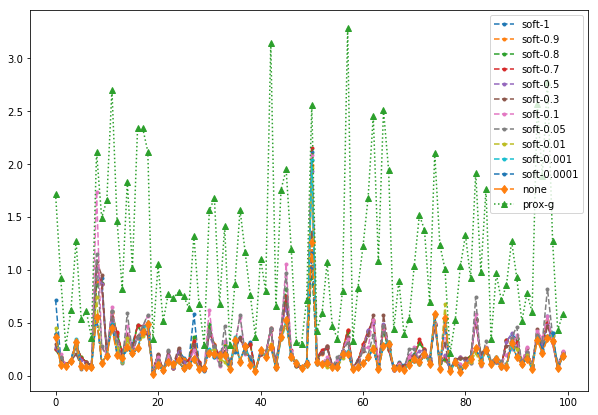

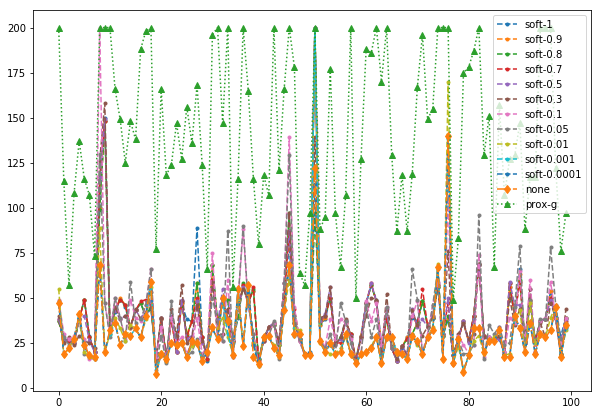

In [5]:
fig = plt.figure(figsize=(10,7))
for key, result in results.items():
    plt.plot(result["time"], result["marker"], label=key)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,7))
for key, result in results.items():
    plt.plot(result["iterations"], result["marker"], label=key)
plt.legend()
plt.show()

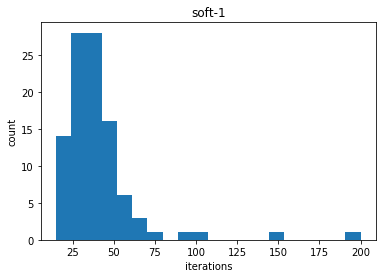

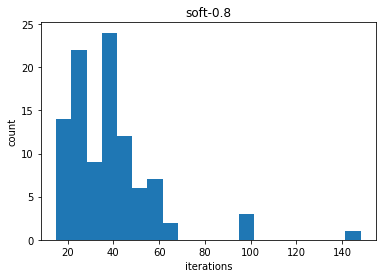

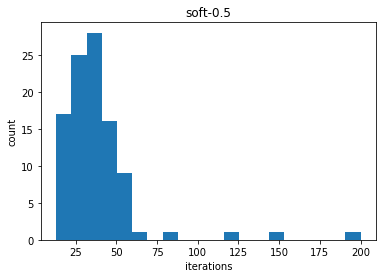

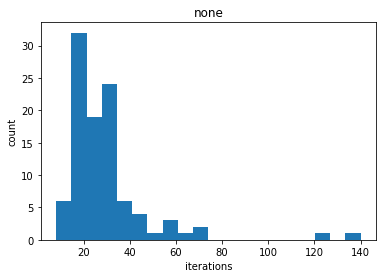

In [6]:
for key in ["soft-1", "soft-0.8", "soft-0.5", "none"]:
    plt.hist(results[key]["iterations"], bins=20)
    plt.xlabel("iterations")
    plt.ylabel("count")
    plt.title(key)
    plt.show()

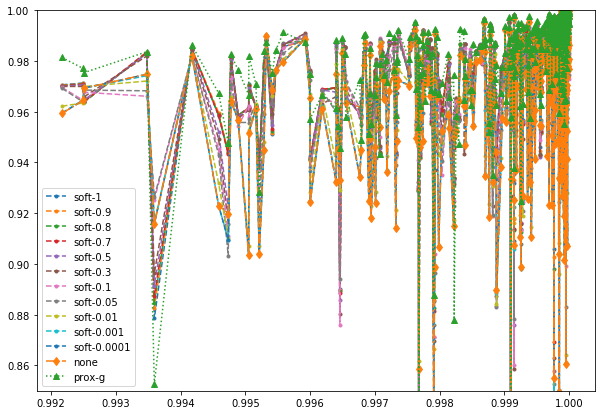

In [7]:
fig = plt.figure(figsize=(10,7))
idx = np.argsort(symmetry)
for k, result in results.items():
    plt.plot(symmetry[idx], result["correlation"][idx], result["marker"], label=k)

plt.ylim([.85, 1])
plt.legend()
plt.show()

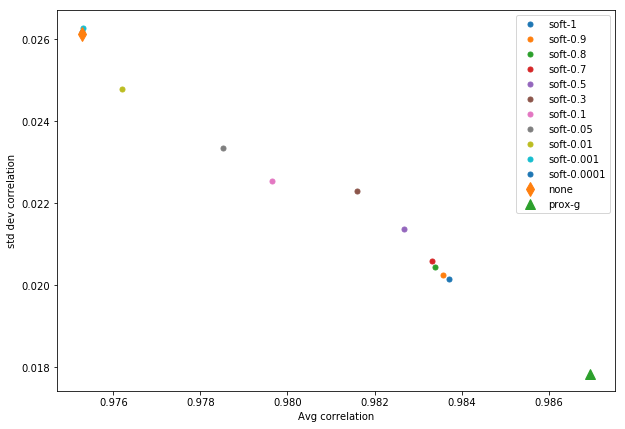

In [8]:
fig = plt.figure(figsize=(10,7))
for k, result in results.items():
    clip = result["correlation"] > np.min(result["correlation"])
    mean = np.mean(result["correlation"][clip])
    std = np.std(result["correlation"][clip])
    plt.plot(mean, std, result["marker"][0], label=k, ms=10)
plt.xlabel("Avg correlation")
plt.ylabel("std dev correlation")
plt.legend()
plt.show()

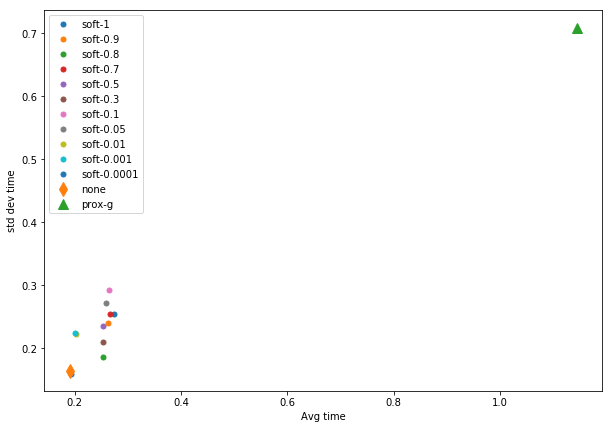

In [9]:
fig = plt.figure(figsize=(10,7))
for k, result in results.items():
    mean = np.mean(result["time"])
    std = np.std(result["time"])
    plt.plot(mean, std, result["marker"][0], label=k, ms=10)
plt.legend()
plt.xlabel("Avg time")
plt.ylabel("std dev time")
plt.show()

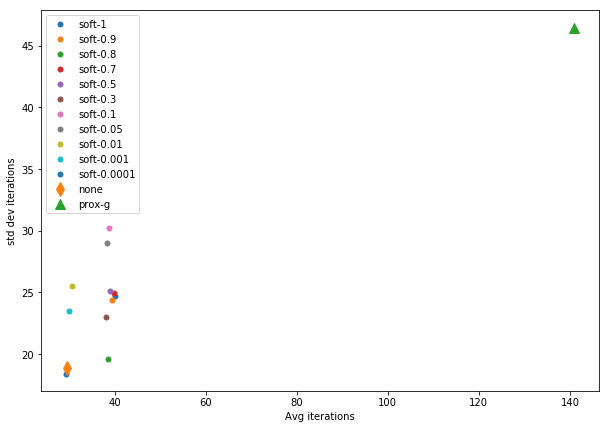

In [10]:
fig = plt.figure(figsize=(10,7))
for k, result in results.items():
    mean = np.mean(result["iterations"])
    std = np.std(result["iterations"])
    plt.plot(mean, std, result["marker"][0], label=k, ms=10)
plt.legend()
plt.xlabel("Avg iterations")
plt.ylabel("std dev iterations")
plt.show()

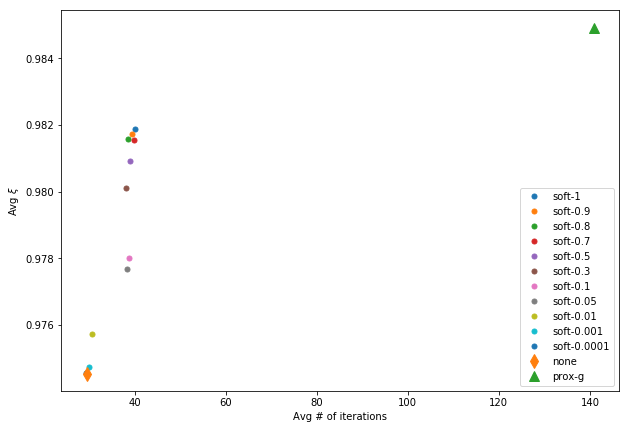

In [11]:
fig = plt.figure(figsize=(10,7))
for k, result in results.items():
    c_mean = np.mean(result["correlation"])
    c_std = np.std(result["correlation"])
    i_mean = np.mean(result["iterations"])
    i_std = np.std(result["iterations"])
    #plt.errorbar(i_mean, c_mean, xerr=i_std, yerr=c_std, label=k)
    plt.plot(i_mean, c_mean, result["marker"][0], label=k, ms=10)
plt.xlabel("Avg # of iterations")
plt.ylabel(r"Avg $\xi$")
plt.legend()
plt.show()

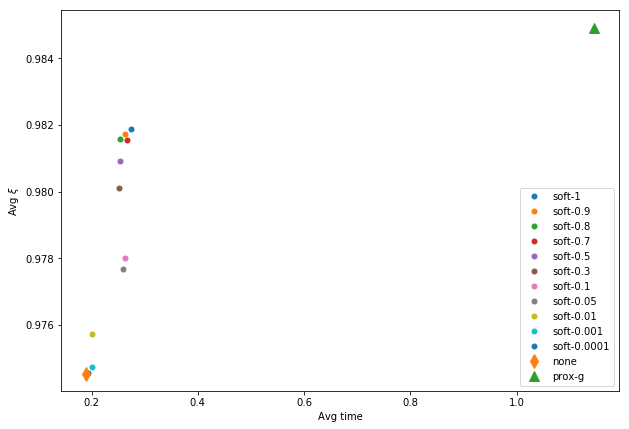

In [12]:
fig = plt.figure(figsize=(10,7))
for k, result in results.items():
    c_mean = np.mean(result["correlation"])
    c_std = np.std(result["correlation"])
    i_mean = np.mean(result["time"])
    i_std = np.std(result["time"])
    #plt.errorbar(i_mean, c_mean, xerr=i_std, yerr=c_std, label=k)
    plt.plot(i_mean, c_mean, result["marker"][0], label=k, ms=10)
plt.xlabel("Avg time")
plt.ylabel(r"Avg $\xi$")
plt.legend()
plt.show()

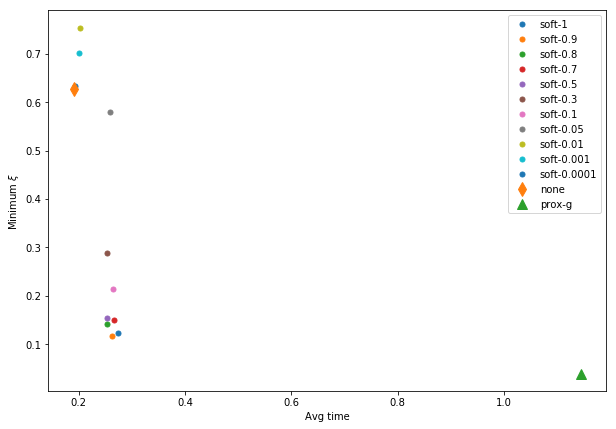

In [13]:
fig = plt.figure(figsize=(10,7))
for k, result in results.items():
    c_mean = np.min(result["correlation"])
    c_std = np.std(result["correlation"])
    i_mean = np.mean(result["time"])
    i_std = np.std(result["time"])
    #plt.errorbar(i_mean, c_mean, xerr=i_std, yerr=c_std, label=k)
    plt.plot(i_mean, c_mean, result["marker"][0], label=k, ms=10)
plt.xlabel("Avg time")
plt.ylabel(r"Minimum $\xi$")
plt.legend()
plt.show()

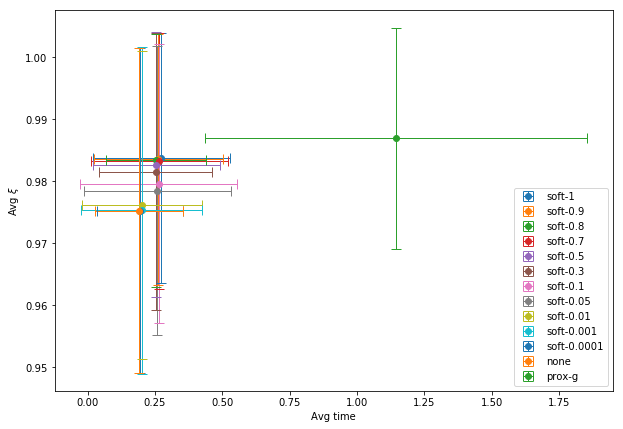

In [14]:
fig = plt.figure(figsize=(10,7))
for k, result in results.items():
    clip = result["correlation"] > np.min(result["correlation"])
    c_mean = np.mean(result["correlation"][clip])
    c_std = np.std(result["correlation"][clip])
    i_mean = np.mean(result["time"])
    i_std = np.std(result["time"])
    plt.errorbar(i_mean, c_mean, xerr=i_std, yerr=c_std, label=k, fmt="o", capsize=5, elinewidth=1)
plt.xlabel("Avg time")
plt.ylabel(r"Avg $\xi$")
plt.legend()
plt.show()

In [15]:
np.min(symmetry)

0.99216903352438213

In [16]:
len(symmetry)

470

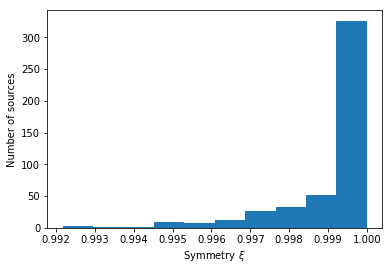

In [17]:
plt.hist(symmetry)
plt.xlabel(r"Symmetry $\xi$")
plt.ylabel("Number of sources")

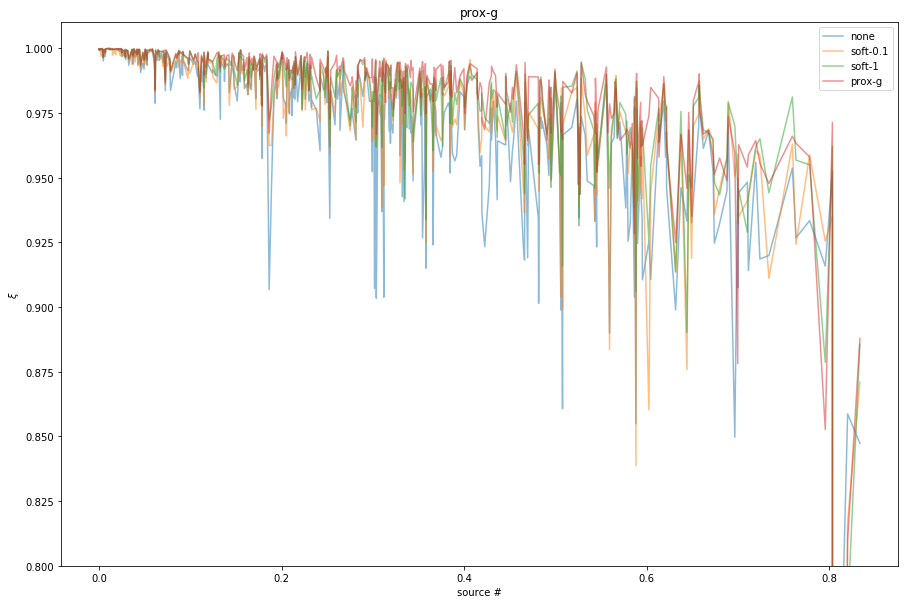

In [18]:
plt.figure(figsize=(15,10))
#for key in ["prox-g", "soft-1", "soft-0.1", "soft-0.05", "none"][::-1]:
for n,key in enumerate(["none", "soft-0.1", "soft-1", "prox-g"]):
    order = np.argsort(blending)
    plt.plot(blending[order], results[key]["correlation"][order], '-', label=key, alpha=.5)
plt.ylim([0.8, 1.01])
plt.xlabel("source #")
plt.ylabel(r"$\xi$")
plt.title(key)
plt.legend()
plt.show()

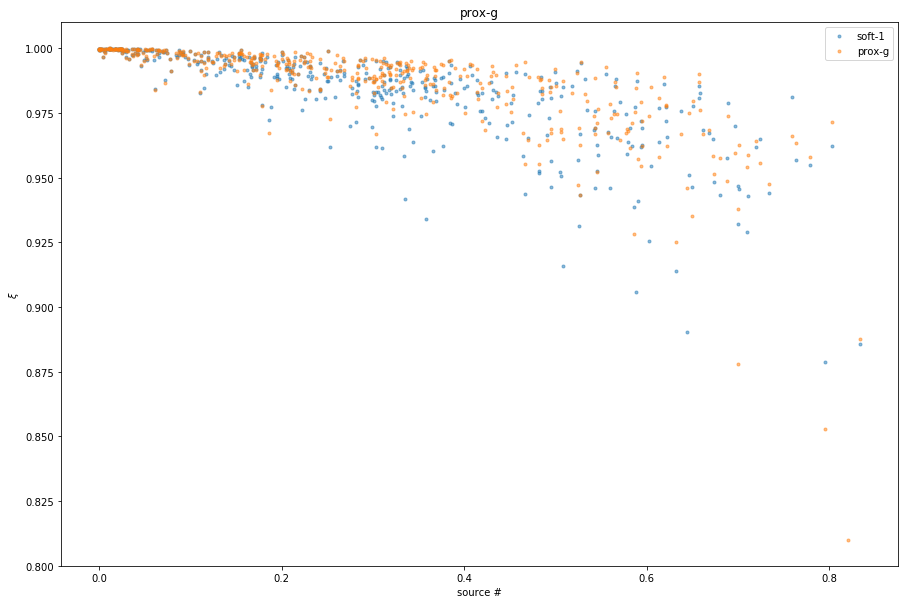

In [19]:
plt.figure(figsize=(15,10))
#for key in ["prox-g", "soft-1", "soft-0.1", "soft-0.05", "none"][::-1]:
for n,key in enumerate(["soft-1", "prox-g"]):
    order = np.argsort(blending)
    plt.plot(blending[order], results[key]["correlation"][order], '.', label=key, alpha=.5)
plt.ylim([0.8, 1.01])
plt.xlabel("source #")
plt.ylabel(r"$\xi$")
plt.title(key)
plt.legend()
plt.show()

In [20]:
symmetry[np.argmin(results["soft-1"]["correlation"])]

0.99909947856927706